In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!unzip -uq '/content/gdrive/My Drive/CheXpert-v1.0-small.zip'

In [148]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score
%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.applications.xception import preprocess_input as pi_xception
from keras.applications.inception_resnet_v2 import preprocess_input as pi_irnv2

In [149]:
MODEL_NAMES = ['xception', 'irnv2']

In [150]:
PATHS_ARCH = {
    'xception' : '/content/gdrive/My Drive/architecture_xception.json',
    'irnv2'    : '/content/gdrive/My Drive/architecture_irnv2.json'
}

PATHS_WEIGHTS = {
    'xception' : '/content/gdrive/My Drive/weights_xception.h5',
    'irnv2'    : '/content/gdrive/My Drive/weights_irnv2.h5'
}

In [151]:
PREPROCESS_INPUTS = {
    'xception' : pi_xception,
    'irnv2'    : pi_irnv2
}

In [152]:
MODELS = {
    'xception' : None,
    'irnv2'    : None
}

PREDICTIONS = {
    'xception' : None,
    'irnv2'    : None
} 

Y_HAT = {
    'xception' : None,
    'irnv2'    : None
}

THRESHOLDS = {
    'xception' : None,
    'irnv2'    : None
}

In [153]:
 def build_models():
  for model_name in MODEL_NAMES: 
      json_file = open(PATHS_ARCH[model_name], 'r')
      model_architecture = json_file.read()
      json_file.close()
      model = model_from_json(model_architecture)
      model.load_weights(PATHS_WEIGHTS[model_name])
      MODELS[model_name] = model

In [154]:
def get_probabilities(raw_img):
  predictions = {
      'xception' : None,
      'irnv2'    : None
  }
  for model_name in MODEL_NAMES: 
    img = preprocess(raw_img, preproc_func = PREPROCESS_INPUTS[model_name])
    model = MODELS[model_name]
    predictions[model_name] = model.predict(img)[0]
  return predictions

In [155]:
def preprocess(raw_img, preproc_func = None):
  img = cv2.resize(raw_img, (224, 224))
  if preproc_func != None:
    img = preproc_func(img)
  # img = img/255.
  img = img.reshape(1, 224, 224, 3)
  return img

In [156]:
CLASSES = [ 
  'Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Pleural Effusion'
]
N_CLASSES = len(CLASSES)
df_val = pd.read_csv('CheXpert-v1.0-small/valid.csv')
df_val = df_val[[
  'Path', 
  'Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Pleural Effusion'
]]
y_true = df_val[CLASSES].to_numpy()

In [157]:
build_models()

In [158]:
preds = []
for filename in tqdm(df_val.Path):
  raw_img = cv2.imread(filename)
  preds.append(get_probabilities(raw_img))

for model_name in MODEL_NAMES:
  PREDICTIONS[model_name] = np.array([p[model_name] for p in preds])

100%|██████████| 234/234 [02:12<00:00,  1.77it/s]


In [159]:
def plot_roc(prediction):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')

  for i in range(N_CLASSES):
    fpr, tpr, thresholds = roc_curve(y_true[:, i], prediction[:, i])
    individual_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= (CLASSES[i] + '(area = {0:.3g})'.format(individual_auc)))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

In [160]:
def get_opt_thresh(prediction):
  J_stats = [None]*N_CLASSES
  opt_thresholds = [None]*N_CLASSES
  for i in range(N_CLASSES):
    fpr, tpr, thresholds = roc_curve(y_true[:, i], prediction[:, i])
    J_stats[i] = tpr - fpr # sensitivity - (1 - specificity)
    opt_thresholds[i] = thresholds[np.argmax(J_stats[i])]
  return opt_thresholds

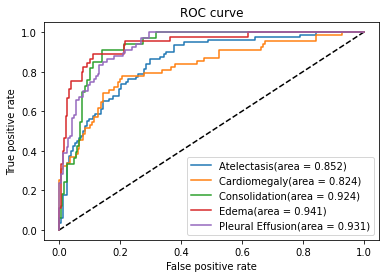

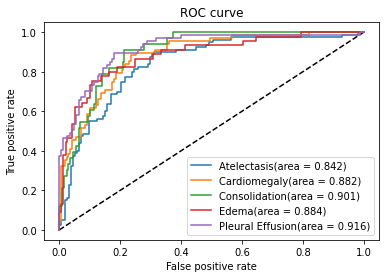

In [161]:
for model_name in MODEL_NAMES:
  plot_roc(PREDICTIONS[model_name])

In [162]:
for model_name in MODEL_NAMES:
  THRESHOLDS[model_name] = get_opt_thresh(PREDICTIONS[model_name])

In [163]:
def predict(preds, thresh):
  y_hat = np.zeros(preds.shape)
  for i in range(N_CLASSES):
    y_hat[:, i] = preds[:, i] >= thresh[i]
  return y_hat

In [164]:
for model_name in MODEL_NAMES:
  Y_HAT[model_name] = predict(PREDICTIONS[model_name], THRESHOLDS[model_name])

In [165]:
for model_name in MODEL_NAMES:
  print("{} : F1-Score : {}".format(model_name, f1_score(y_true, Y_HAT[model_name], average=None)))
  print("{} : Categorical Accuracy : {}".format(model_name, accuracy_score(y_true, Y_HAT[model_name])))

xception : F1-Score : [0.70769231 0.68387097 0.65934066 0.75471698 0.76821192]
xception : Categorical Accuracy : 0.4658119658119658
irnv2 : F1-Score : [0.72       0.71856287 0.56603774 0.68686869 0.76433121]
irnv2 : Categorical Accuracy : 0.44871794871794873


## Ensemble :

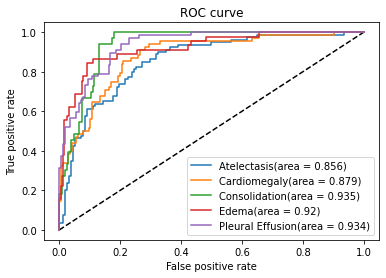


  Thresholds: [0.26264885, 0.04409943, 0.052952945, 0.24443305, 0.19644831]
  F1-Score  : [0.71578947 0.71264368 0.64705882 0.74285714 0.76470588]
  Categorical Accuracy : 0.44871794871794873



In [166]:
"""Ensembling the models"""

sum = 0
for model_name in MODEL_NAMES:
  sum += PREDICTIONS[model_name]
ensembled_predictions = sum/len(MODEL_NAMES)

plot_roc(ensembled_predictions)
thresh = get_opt_thresh(ensembled_predictions)
y_hat = predict(ensembled_predictions, thresh)
f1 = f1_score(y_true, y_hat, average=None)
catacc = accuracy_score(y_true, y_hat)

print("""
  Thresholds: {}
  F1-Score  : {}
  Categorical Accuracy : {}
""".format(thresh, f1, catacc))